<h1> Trading on Binance with XGBoost Price Forecasting </h1>
This workbook is a walkthrough of how price forecasting with XGBoost can be used to simulate a simple trading strategy executed on real Bitcoin data from Binance. The notebook is divided into four chapters:
1. Exploratory Data Analysis and Feature Creation
2. Model Creation
3. Trading Simulation
4. Conclusion

Before going into the first chapter we start with loading some packages we will use throughout the notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_notebook, show
output_notebook()
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from binance.client import Client

Loading BokehJS ...

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<h1> Exploratory Data Analysis and Feature Creation

Import the data set containing OHLCV Bitcoin prices between 2017-01-01 to 2020-02-01 for every 15 minutes.

In [2]:
df = pd.read_csv("/Users/jakobwiren/Dropbox/Coding/Bot/Binance_BTCUSDT_20170101.csv")
df['Time'] = pd.to_datetime(df['Time'])#make datetime

In [3]:
display(df.head())

,Unnamed: 0,Time,Open,High,Low,Close,Volume
0,0,2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061
1,1,2017-08-17 04:15:00,4261.48,4270.41,4261.32,4261.45,9.119865
2,2,2017-08-17 04:30:00,4280.00,4310.07,4267.99,4310.07,21.923552
3,3,2017-08-17 04:45:00,4310.07,4313.62,4291.37,4308.83,13.948531
4,4,2017-08-17 05:00:00,4308.83,4328.69,4304.31,4304.31,5.101153


Drop first column.

In [4]:
df = df.drop(['Unnamed: 0'], axis = 1)

In [5]:
display(df.head())

,Time,Open,High,Low,Close,Volume
0,2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061
1,2017-08-17 04:15:00,4261.48,4270.41,4261.32,4261.45,9.119865
2,2017-08-17 04:30:00,4280.00,4310.07,4267.99,4310.07,21.923552
3,2017-08-17 04:45:00,4310.07,4313.62,4291.37,4308.83,13.948531
4,2017-08-17 05:00:00,4308.83,4328.69,4304.31,4304.31,5.101153


Let's look at some initial statistics at the data as well as plotting the close price over time. I am using Bokeh to plot the data in an interactive fram which enables me to zoom into different parts of the data as I wish.

In [6]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87289 entries, 0 to 87288
Data columns (total 6 columns):
Time      87289 non-null datetime64[ns]
Open      87289 non-null float64
High      87289 non-null float64
Low       87289 non-null float64
Close     87289 non-null float64
Volume    87289 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 4.0 MB


,Open,High,Low,Close,Volume
count,87289.000000,87289.000000,87289.000000,87289.000000,87289.000000
mean,7536.241756,7560.807045,7510.383124,7536.268695,364.013618
std,2816.681197,2834.480469,2797.316850,2816.622884,436.838805
min,2830.000000,2880.010000,2817.000000,2820.000000,0.000000
25%,5624.980000,5639.990000,5610.000000,5624.980000,142.351631
50%,7327.480000,7344.950000,7311.000000,7326.900000,256.692541
75%,9208.330000,9231.350000,9180.060000,9209.110000,435.298532
max,19756.000000,19798.680000,19680.200000,19756.020000,10340.338241


In [7]:
f = figure(width=900, height=400, x_axis_type='datetime', x_axis_label = 'Time', y_axis_label = 'Close Price (USD)')
f.line(df['Time'], df['Close'], line_width=2)
show(f)

We can see from the chart the Bitcoin had its high at almost 20,000 USD in Dec 2019 and later dropped to below 5,000 to stabalize around 10,000 in the end of 2019. As a first step, let's look at the autocorrelation plot which indicates if correlation exists with previous values. In this case, my hypothesis is that there should be high autocorrelation since previous prices affect the next price.

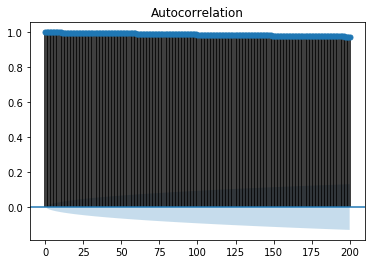

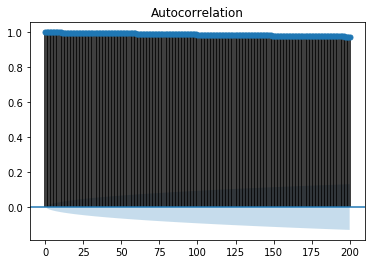

In [8]:
plot_acf(df['Close'], lags = 200)

When plotting the autocorrelation we can see extremely high autocorrelation which makes sense since the next price will always be very very similiar to the previous one, the previous one before that and so on. We can therefore accept the hypothesis.

In [9]:
#plot_pacf(df['Close'], lags = 10) #slow don't run

In order for the model to find patterns to learn the behavior of the data we create some features from previous data points as well as the dates

In [10]:
def preprocess_data(df):
    #make datetime
    df['Time'] = pd.to_datetime(df['Time'], unit ='s')
    
    #create features for dates
    df['Month'] = pd.DatetimeIndex(df['Time']).month
    df['Year'] = pd.DatetimeIndex(df['Time']).year
    df['Day'] = pd.DatetimeIndex(df['Time']).day
    df['Hour'] = pd.DatetimeIndex(df['Time']).hour
    df['Weekend'] = [1 if x >=5 else 0 for x in df['Day']]
    df.head()

    #lag k
    df['lag k = -1'] = df['Close'].shift(1)
    df['lag k = -2'] = df['Close'].shift(2)
    df['lag k = -3'] = df['Close'].shift(3)
    #lag volume
    df['vol lag k = -1'] = df['Volume'].shift(1)
    df['vol lag k = -2'] = df['Volume'].shift(2)
    df['vol lag k = -3'] = df['Volume'].shift(3)
    #lag Low
    df['low lag k = -1'] = df['Low'].shift(1)
    df['low lag k = -2'] = df['Low'].shift(2)
    df['low lag k = -3'] = df['Low'].shift(3)
    #lag High
    df['high lag k = -1'] = df['High'].shift(1)
    df['high lag k = -2'] = df['High'].shift(2)
    df['high lag k = -3'] = df['High'].shift(3)
    #lag Open
    df['open lag k = -1'] = df['Open'].shift(1)
    df['open lag k = -2'] = df['Open'].shift(2)
    df['open lag k = -3'] = df['Open'].shift(3)
    #df['rsi'] = computeRSI(df['Close'], 12)
    df.head()
    #remove 10 rows
    df = df.iloc[3:]
    return df

In [11]:
df = preprocess_data(df)
df = df[df['Time'] > '2019-07-01']
df.head()

,Time,Open,High,Low,Close,Volume,Month,Year,Day,Hour,...,vol lag k = -3,low lag k = -1,low lag k = -2,low lag k = -3,high lag k = -1,high lag k = -2,high lag k = -3,open lag k = -1,open lag k = -2,open lag k = -3
65192,2019-07-01 00:15:00,11003.43,11040.00,10918.81,11000.15,1369.357454,7,2019,1,0,...,1697.645829,10719.00,10766.03,10982.17,11047.01,11040.04,11090.90,10854.10,11035.07,11014.34
65193,2019-07-01 00:30:00,11007.65,11020.00,10906.51,10972.52,697.596742,7,2019,1,0,...,2783.130228,10918.81,10719.00,10766.03,11040.00,11047.01,11040.04,11003.43,10854.10,11035.07
65194,2019-07-01 00:45:00,10975.74,11104.41,10973.35,11091.54,936.917592,7,2019,1,0,...,2439.744055,10906.51,10918.81,10719.00,11020.00,11040.00,11047.01,11007.65,11003.43,10854.10
65195,2019-07-01 01:00:00,11091.06,11171.42,11046.05,11076.94,1501.967780,7,2019,1,1,...,1369.357454,10973.35,10906.51,10918.81,11104.41,11020.00,11040.00,10975.74,11007.65,11003.43
65196,2019-07-01 01:15:00,11076.92,11076.92,10981.01,11043.70,759.803135,7,2019,1,1,...,697.596742,11046.05,10973.35,10906.51,11171.42,11104.41,11020.00,11091.06,10975.74,11007.65


Let's look at the correlation with the Close price for each of the feature.

In [12]:
correlations = df.corr().abs() #this returns all correlations in the entire df
correlations = correlations['Close'] #this returns all correlations against the close price
correlations_sorted = correlations.sort_values(kind="quicksort", ascending = False) #sort the correlations ascending
display(correlations_sorted)

Close              1.000000
High               0.999824
Low                0.999813
Open               0.999690
lag k = -1         0.999689
high lag k = -1    0.999524
low lag k = -1     0.999501
open lag k = -1    0.999380
lag k = -2         0.999379
high lag k = -2    0.999221
low lag k = -2     0.999185
open lag k = -2    0.999082
lag k = -3         0.999081
high lag k = -3    0.998914
low lag k = -3     0.998877
open lag k = -3    0.998766
Month              0.237635
Day                0.182995
Year               0.099229
vol lag k = -3     0.022488
vol lag k = -2     0.022117
vol lag k = -1     0.021615
Volume             0.021104
Weekend            0.007993
Hour               0.002840
Name: Close, dtype: float64

Not surprisingly we see that the previous price have very high correlation. We can also see that month, day and year have quite low correlation which makes sense since we don't really have any seasonality in the data. After having our features created it is time to create our model to see the performance.

<h1> Model Creation

We start by applying all the features we created in a basic XGBoost model. So let's split the data into test and training data.

In [13]:
X = df[['Month', 'Year',
       'Day', 'Hour', 'Weekend', 'lag k = -1', 'lag k = -2', 'lag k = -3',
       'vol lag k = -1', 'vol lag k = -2', 'vol lag k = -3', 'low lag k = -1',
       'low lag k = -2', 'low lag k = -3', 'high lag k = -1',
       'high lag k = -2', 'high lag k = -3', 'open lag k = -1',
       'open lag k = -2', 'open lag k = -3']]
y = df['Close']

#normalize data in order to prevent scaling faults for different features
X_normalized = pd.DataFrame(preprocessing.normalize(X))

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.3, shuffle = False)

In [14]:
y_train.describe()
X_train.describe()

,Month,Year,Day,Hour,Weekend,lag k = -1,lag k = -2,lag k = -3,vol lag k = -1,vol lag k = -2,vol lag k = -3,low lag k = -1,low lag k = -2,low lag k = -3,high lag k = -1,high lag k = -2,high lag k = -3,open lag k = -1,open lag k = -2,open lag k = -3
count,15467.00000,15467.0,15467.000000,15467.000000,15467.000000,15467.000000,15467.000000,15467.000000,15467.000000,15467.000000,15467.000000,15467.000000,15467.000000,15467.000000,15467.000000,15467.000000,15467.000000,15467.000000,15467.000000,15467.000000
mean,9.14838,2019.0,15.215297,11.505722,0.851102,9441.778699,9441.992837,9442.219595,489.084010,489.221076,489.313171,9417.643806,9417.853974,9418.078358,9465.003608,9465.229253,9465.459555,9441.994176,9442.220945,9442.447189
std,1.53397,0.0,8.973138,6.917791,0.355999,1342.867311,1342.828427,1342.801266,567.214697,567.512826,567.593341,1336.105847,1336.062263,1336.033531,1348.930890,1348.902435,1348.875887,1342.824810,1342.797661,1342.767726
min,7.00000,2019.0,1.000000,0.000000,0.000000,6540.210000,6540.210000,6540.210000,31.170067,31.170067,31.170067,6515.000000,6515.000000,6515.000000,6585.360000,6585.360000,6585.360000,6540.170000,6540.170000,6540.170000
25%,8.00000,2019.0,7.000000,6.000000,1.000000,8225.215000,8225.555000,8225.705000,203.403445,203.403445,203.403445,8209.995000,8210.000000,8210.000000,8240.110000,8240.235000,8240.335000,8225.445000,8225.600000,8225.695000
50%,9.00000,2019.0,15.000000,12.000000,1.000000,9573.120000,9573.160000,9573.260000,319.564613,319.564613,319.586045,9551.000000,9551.380000,9551.600000,9591.660000,9591.760000,9592.000000,9573.060000,9573.060000,9573.590000
75%,10.00000,2019.0,23.000000,17.000000,1.000000,10365.810000,10365.955000,10366.215000,543.797881,543.797881,543.851400,10342.935000,10343.000000,10343.190000,10388.995000,10389.000000,10389.030000,10366.010000,10366.090000,10366.190000
max,12.00000,2019.0,31.000000,23.000000,1.000000,13086.430000,13086.430000,13086.430000,9305.628362,9305.628362,9305.628362,13030.510000,13030.510000,13030.510000,13147.080000,13147.080000,13147.080000,13081.680000,13081.680000,13081.680000


RMSE: 31.523714
MAE: 22.230888


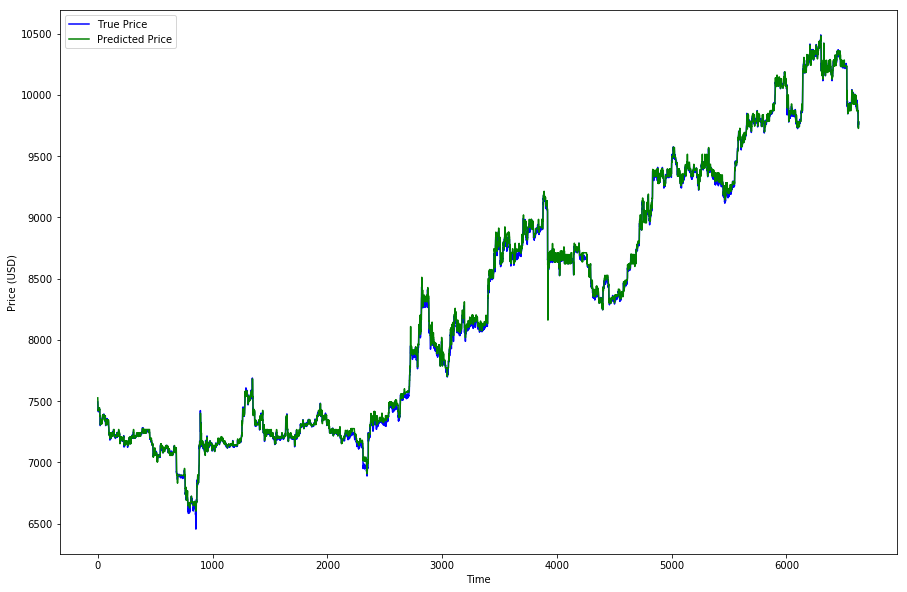

In [15]:
#create XGboost
xgb_reg = xgb.XGBRegressor()


# Fit the model
model_xgboost = xgb_reg.fit(X_train, y_train)


model_xgboost = xgb_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, model_xgboost))
mae = mean_absolute_error(y_test, model_xgboost)
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))

fig= plt.figure(figsize=(15,10))
plt.plot(np.arange(0,len(y_test)), y_test, color = 'blue', label = 'True Price')
plt.plot(np.arange(0,len(y_test)), model_xgboost, color = 'green', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()

After trying different sets of features and settings for the XGBoost model, below are the best combinations to minimize the RMSE.

In [16]:
X = df[[
       'lag k = -1']]
y = df['Close']

#normalize data in order to prevent scaling faults for different features
X_normalized = pd.DataFrame(preprocessing.normalize(X))

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.3, shuffle = False)

In [17]:
y_train.describe()

count    15467.000000
mean      9441.553577
std       1342.897364
min       6540.210000
25%       8224.815000
50%       9573.110000
75%      10365.675000
max      13086.430000
Name: Close, dtype: float64

In [18]:
y_test.describe()

count     6630.000000
mean      8298.982544
std       1068.200418
min       6455.940000
25%       7245.352500
50%       8174.090000
75%       9276.565000
max      10488.780000
Name: Close, dtype: float64

RMSE: 27.753692
MAE: 18.250744


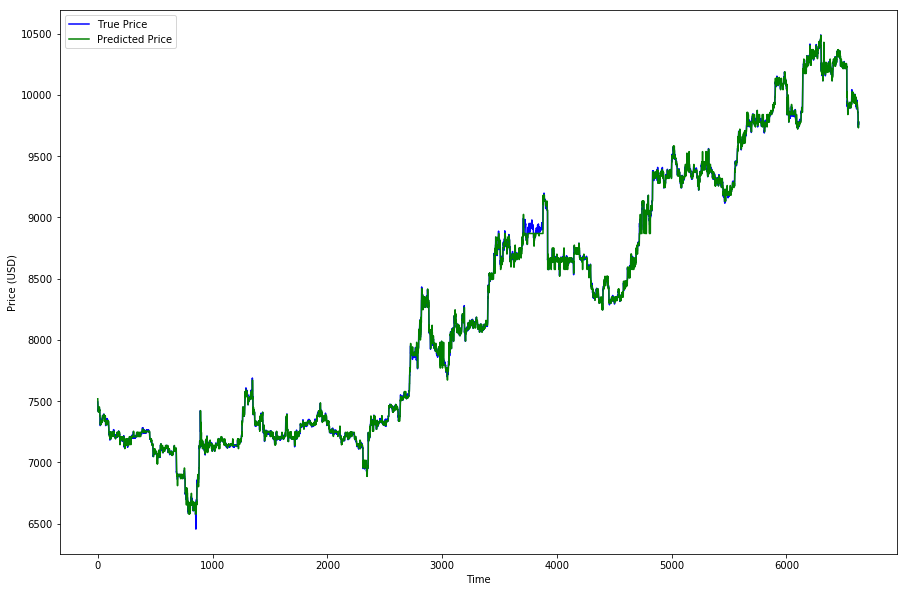

In [19]:
#create XGboost
xgb_reg_15m = xgb.XGBRegressor(learning_rate = 0.65, gamma = 2, n_estimators = 100, min_child_weight = 5)


# Fit the model
model_xgboost = xgb_reg_15m.fit(X_train, y_train)


model_xgboost_15m = xgb_reg_15m.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, model_xgboost_15m))
mae = mean_absolute_error(y_test, model_xgboost_15m)
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))

fig= plt.figure(figsize=(15,10))
plt.plot(np.arange(0,len(y_test)), y_test, color = 'blue', label = 'True Price')
plt.plot(np.arange(0,len(y_test)), model_xgboost_15m, color = 'green', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()

In [20]:
xgb_reg_15m.get_xgb_params()
#xgb_rscv.plot_importance(xg_reg)

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 2,
 'learning_rate': 0.65,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 5,
 'missing': None,
 'n_estimators': 100,
 'nthread': 1,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': 1,
 'subsample': 1}

Best combination of features for 15-min forecast:

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 2,
 'learning_rate': 0.65,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 5,
 'missing': None,
 'n_estimators': 100,
 'nthread': 1,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': 1,
 'subsample': 1}

It should be taken into consideration that model is set to minimize the RMSE. Hence, it makes sense that we get the best result from using only lag k = - 1. The result of this, is that model will always be a little bit behind the future but yet provide a good RMSE since the adjacent prices are typically very similar.

Consequently it is recommended to look into optimizing on other evaluation methods in order to create a better prediction model with purpose for trading.

<h1> Trading Simulation </h1>
After predicting the price with XGBoost. Let's apply this prediction to a simple trading strategy. The bot will simply buy all available money on the account if the next price point is predicted to be larger than the current price. Similarily if the bot predicts the next price will be smaller than the current one, it will sell all the holdings. 

We will call the latest 4 days of 15-minute data using the Binance Python API to try our strategy.

In [ ]:
#log in to client with your keys to your account below.
api_key = 
secret_key = 
client = Client(api_key, secret_key)
currency = 'BTCUSDT'

In [22]:
#donwload latest data and prepare for prediction
BTC = client.get_klines(symbol = currency, interval = Client.KLINE_INTERVAL_15MINUTE)
test_df = pd.DataFrame(BTC)
test_df = test_df.drop([6,7,8,9,10,11], axis = 1)
test_df.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
test_df['Time'] = test_df['Time']/1000
#print(test_df)
test_df = preprocess_data(test_df)
#print(test_df)

RMSE: 28.530441


/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=10,min_periods=0,adjust=True,ignore_na=False).mean()


Text(0.5,1,'Predicted 15-min Bitcoin price')

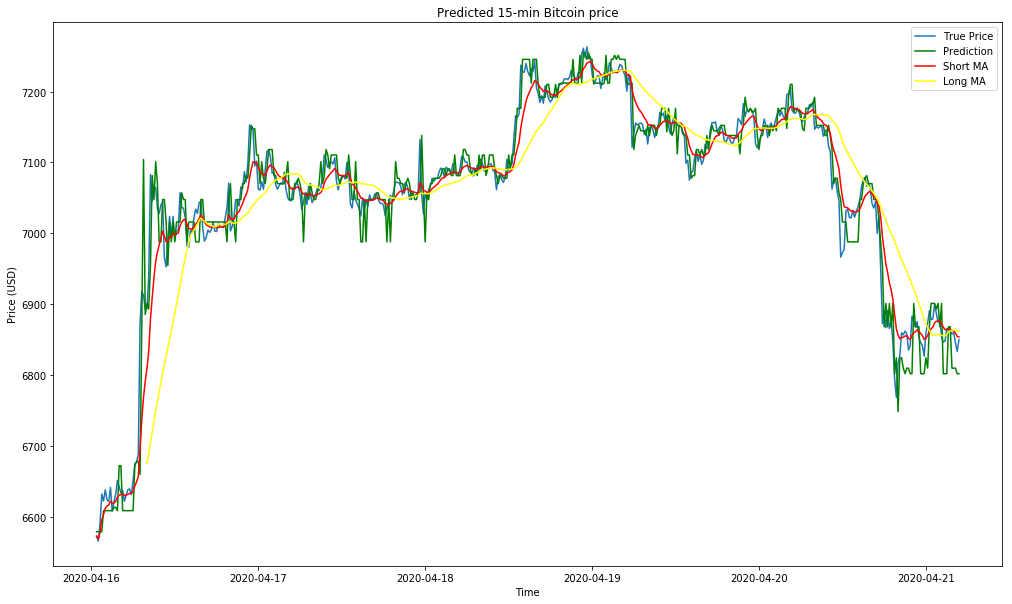

In [23]:
#save the true prices
trade_df = pd.DataFrame(test_df['Close'],dtype = float)
trade_df.columns = ['True Price']
trade_df['Time'] = test_df['Time']

#we only use the lastest previous price in the model
input_df =test_df.drop(['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Month', 'Year',
       'Day', 'Hour', 'Weekend', 'lag k = -2', 'lag k = -3',
       'vol lag k = -1', 'vol lag k = -2', 'vol lag k = -3', 'low lag k = -1',
       'low lag k = -2', 'low lag k = -3', 'high lag k = -1',
       'high lag k = -2', 'high lag k = -3', 'open lag k = -1',
       'open lag k = -2', 'open lag k = -3'], axis = 1)
input_df.head()
input_df['lag k = -1'] = input_df['lag k = -1'].astype(float)

#feed the prices into the model and create a series of the output in order to plot it with the true prices
trade_df['Prediction'] = xgb_reg_15m.predict((input_df))


#print(predictions)
#print(true_prices)


#create moving averages
trade_df['EWMA'] = pd.ewma(trade_df['True Price'], span = 10, adjust = True)
trade_df['MA_short'] = trade_df['True Price'].rolling(window=20).mean()
trade_df['MA_long'] = trade_df['True Price'].rolling(window=30).mean()


#print the root mean squared error
rmse2 = np.sqrt(mean_squared_error(trade_df['True Price'], trade_df['Prediction']))
print("RMSE: %f" % (rmse2))

#plot true prices and predicted prices
fig2= plt.figure(figsize=(17,10))
plt.plot(trade_df['Time'], trade_df['True Price'], label ='True Price')
plt.plot(trade_df['Time'], trade_df['Prediction'], color = 'green', label = 'Prediction')
plt.plot(trade_df['Time'],trade_df['EWMA'], color = 'red', label = 'Short MA')
plt.plot(trade_df['Time'],trade_df['MA_long'], color = 'yellow', label = 'Long MA')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.title('Predicted 15-min Bitcoin price')

Let's try trading on the latest data

In [24]:
#This model buys and sells when the predicted next price is greater or smaller than the currently recorded price
def trade(df): 
    FIAT_wallet, BTC_wallet, Start_value = get_balance()
    count = 0
    long_position = False
    for index in df.index:
        if count > 1:
            #if short MA is larger than long MA & and we are not already in a long position --> buy
            if df['Prediction'][index] > df['True Price'][index - 1] and long_position == False:
                long_position = True
                FIAT_wallet, BTC_wallet = buy(FIAT_wallet, BTC_wallet, df['True Price'][index])
                
            #if short MA is smaller than long MA & we are in a long position --> sell
            elif df['Prediction'][index] < df['True Price'][index - 1] and long_position == True:
                long_position = False
                FIAT_wallet, BTC_wallet = sell(FIAT_wallet, BTC_wallet, df['True Price'][index])
                #print("sell")
        count = count + 1
        latest_price = df['True Price'][index]
    if FIAT_wallet == 0:
        FIAT_wallet, BTC_wallet = sell(FIAT_wallet, BTC_wallet, df['True Price'][index])
    End_value = FIAT_wallet
    return Start_value, End_value

In [25]:
def buy(FIAT_wallet, BTC_wallet, price):
    BTC_wallet = BTC_wallet + 1*FIAT_wallet/price #fill BTC wallet with fiat money based on true BTC price
    FIAT_wallet = FIAT_wallet - FIAT_wallet
    #print("Bought at: ", price)
    return FIAT_wallet, BTC_wallet

In [26]:
def sell(FIAT_wallet, BTC_wallet, price):
    FIAT_wallet = FIAT_wallet + 1*BTC_wallet*price #fill wallet with Fiat money based on true BTC price
    BTC_wallet = 0
    #print("Sold at: ", price)
    return FIAT_wallet, BTC_wallet

In [27]:
def get_balance():
    Start_value = 10000
    FIAT_wallet = Start_value
    BTC_wallet = 0
    return FIAT_wallet, BTC_wallet, Start_value

In [28]:
Start_value, End_value = trade(trade_df)
print("Start value:", Start_value)
print("End value:", End_value)
print("Return:", End_value/Start_value)

Start value: 10000
End value: 10314.051856918057
Return: 1.0314051856918056


<h1> 4. Conclusion </h1> 
To summarize we can conclude, that with some simlpe measures it was possible to predict the next 15-minute price with help of XGBoost using the most recent price.

Using the price prediction, it was possible to make a profit of 3.5% on the latest 5 days of 15-minute Bitcoin data from Binance with a simple trading strategy, without taking exchange fees into consideration.

Going forward, it might beneficial to look into more sophisticated methods to improve the XGBoost model with purpose for trading and apply more complex trading strategies for constand profit in a longer time period.